# arXiv Metadata EDA

In [ ]:
import os
import re
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore")

DATA_PATH = os.getenv("ARXIV_METADATA_CSV", "arxiv_papers_metadata.csv")
OUT_DIR = Path(os.getenv("ARXIV_EDA_OUTDIR", "eda_artifacts"))
OUT_DIR.mkdir(parents=True, exist_ok=True)

PRIMARY_CATEGORIES = [
    "cs.LG",
    "stat.ML",
    "cs.AI",
    "cs.CL",
    "cs.CV",
]

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

In [2]:
df = pd.read_csv(f"../data/raw/{DATA_PATH}", low_memory=False)
display(df.head(3))

,arxiv_id,title,abstract,authors,categories,primary_category,doi,journal_ref,update_date,latest_version,latest_version_created
0,0704.0047,Intelligent location of simultaneously active ...,The intelligent acoustic emission locator is d...,T. Kosel and I. Grabec,"{cs.NE,cs.AI}",cs.NE,NaN,NaN,2009-09-29,1,2007-04-01 13:06:50+00
1,0704.0050,Intelligent location of simultaneously active ...,Part I describes an intelligent acoustic emiss...,T. Kosel and I. Grabec,"{cs.NE,cs.AI}",cs.NE,NaN,NaN,2007-05-23,1,2007-04-01 18:53:13+00
2,0704.0304,The World as Evolving Information,This paper discusses the benefits of describin...,Carlos Gershenson,"{cs.IT,cs.AI,math.IT,q-bio.PE}",cs.IT,10.1007/978-3-642-18003-3_10,"Minai, A., Braha, D., and Bar-Yam, Y., eds. Un...",2013-04-05,3,2010-10-13 19:49:16+00


In [3]:
print("Number of papers:", df.shape[0])

Number of papers: 511882


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511882 entries, 0 to 511881
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   arxiv_id                511882 non-null  object
 1   title                   511882 non-null  object
 2   abstract                511882 non-null  object
 3   authors                 511882 non-null  object
 4   categories              511882 non-null  object
 5   primary_category        511882 non-null  object
 6   doi                     62405 non-null   object
 7   journal_ref             47445 non-null   object
 8   update_date             511882 non-null  object
 9   latest_version          511882 non-null  int64 
 10  latest_version_created  511882 non-null  object
dtypes: int64(1), object(10)
memory usage: 43.0+ MB


## Normalize types

In [5]:
def parse_authors(author):
    if pd.isna(author):
        return []
    author = str(author)
    parts = re.split(r"\s+and\s+|,|;", author)
    return [p.strip() for p in parts if p.strip()]


def parse_categories(category):
    if pd.isna(category):
        return []
    category = str(category).strip()
    if category.startswith("{") and category.endswith("}"):
        category = category[1:-1]
    return [c.strip() for c in category.split(",") if c.strip()]


def normalize_arxiv_metadata(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["arxiv_id"] = df["arxiv_id"].astype("string")

    for col in ["title", "abstract", "doi", "journal_ref"]:
        if col in df.columns:
            df[col] = df[col].astype("string")

    df["authors"] = df["authors"].apply(parse_authors)
    df["categories"] = df["categories"].apply(parse_categories)
    df["primary_category"] = df["primary_category"].astype("category")
    df["update_date"] = pd.to_datetime(df["update_date"], errors="coerce")
    df["latest_version_created"] = pd.to_datetime(
        df["latest_version_created"], errors="coerce", utc=True
    )
    df["latest_version"] = (
        df["latest_version"].astype("string").str.extract(r"(\d+)").astype("Int64")
    )

    return df

In [6]:
df = normalize_arxiv_metadata(df)
df.dtypes

arxiv_id                       string[python]
title                          string[python]
abstract                       string[python]
authors                                object
categories                             object
primary_category                     category
doi                            string[python]
journal_ref                    string[python]
update_date                    datetime64[ns]
latest_version                          Int64
latest_version_created    datetime64[ns, UTC]
dtype: object

## Check for empty values

In [7]:
df.isna().sum()

arxiv_id                       0
title                          0
abstract                       0
authors                        0
categories                     0
primary_category               0
doi                       449477
journal_ref               464437
update_date                    0
latest_version                 0
latest_version_created         0
dtype: int64

Empty `doi` and `journal ref` is okay, we won't use them

## Check for duplicates

In [8]:
duplicates = (
    df[df.duplicated(subset=["title"], keep=False)]
    .groupby("title")
    .agg(
        n_rows=("arxiv_id", "count"),
        n_ids=("arxiv_id", "nunique"),
        versions=("latest_version", lambda x: sorted(x.dropna().unique())),
        first_year=("latest_version_created", "min"),
        last_year=("latest_version_created", "max"),
    )
    .sort_values("n_rows", ascending=False)
)

display(duplicates.head(10))

,n_rows,n_ids,versions,first_year,last_year
title,,,,,
Discussion: Latent variable graphical model selection via convex\n optimization,4,4,[1],2012-11-05 09:36:40+00:00,2012-11-05 10:32:57+00:00
A Game-Theoretic Analysis of Updating Sets of Probabilities,2,2,[1],2007-11-20 23:34:12+00:00,2014-07-27 05:37:10+00:00
OCTAL: Graph Representation Learning for LTL Model Checking,2,2,"[1, 2]",2022-07-26 04:09:22+00:00,2023-08-19 15:11:18+00:00
On-device Sora: Enabling Training-Free Diffusion-based Text-to-Video\n Generation for Mobile Devices,2,2,[2],2025-03-31 07:22:14+00:00,2025-04-01 02:33:18+00:00
On the Min-cost Traveling Salesman Problem with Drone,2,2,"[3, 4]",2016-05-26 13:14:33+00:00,2017-07-29 18:08:35+00:00
On the Generalization of Stochastic Gradient Descent with Momentum,2,2,"[2, 3]",2021-09-23 18:22:12+00:00,2024-01-15 14:55:29+00:00
On the Conditional Independence Implication Problem: A Lattice-Theoretic\n Approach,2,2,[1],2008-10-31 15:52:27+00:00,2014-08-09 05:22:43+00:00
On Improving Deep Reinforcement Learning for POMDPs,2,2,"[2, 6]",2018-05-08 13:15:51+00:00,2018-05-24 14:13:20+00:00
OmniDrive: A Holistic Vision-Language Dataset for Autonomous Driving\n with Counterfactual Reasoning,2,2,[2],2025-04-16 15:00:11+00:00,2025-04-16 15:12:21+00:00


It seems that some articles have the same titles. \
Let's check them for uniqueness by `id`

In [9]:
duplicates[duplicates["n_ids"] != duplicates["n_rows"]].count()

n_rows        0
n_ids         0
versions      0
first_year    0
last_year     0
dtype: int64

All papers with the same title are actually unique.

## Preprocess

- Drop papers created before 2020;
- Keep only ml categories.

In [10]:
df = df.loc[
    (df["latest_version_created"].dt.year > 2020)  # noqa: PLR2004
    & (df["primary_category"].isin(PRIMARY_CATEGORIES))
]
df["primary_category"] = df["primary_category"].cat.remove_unused_categories()

In [11]:
df.shape[0]

283087

## Category analysis

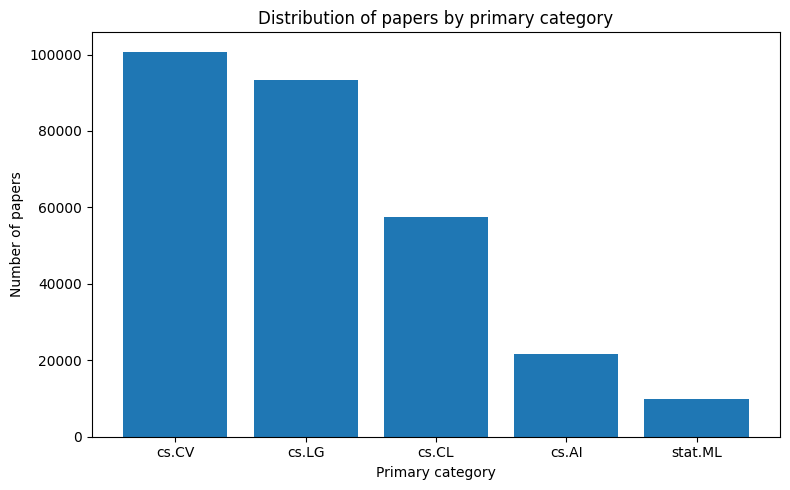

In [12]:
cat_counts = df["primary_category"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(cat_counts.index, cat_counts.to_numpy())
plt.xlabel("Primary category")
plt.ylabel("Number of papers")
plt.title("Distribution of papers by primary category")
plt.tight_layout()
plt.show()

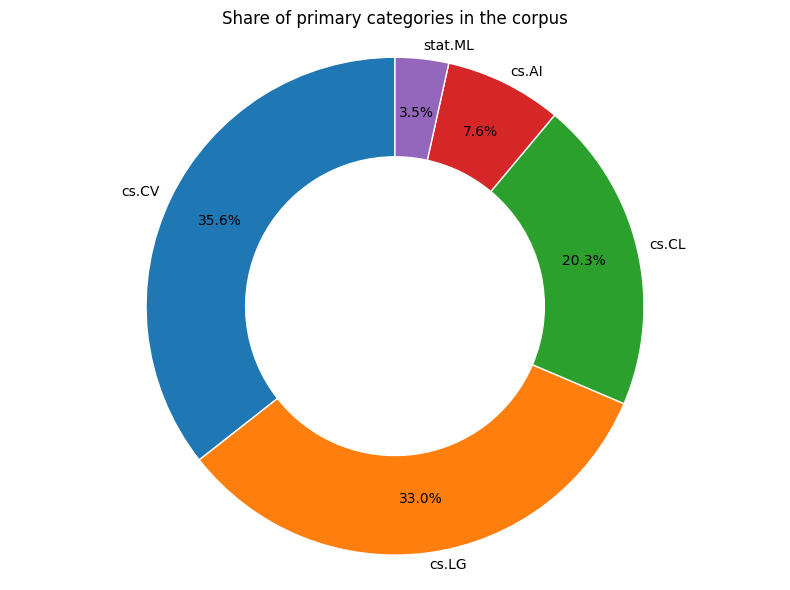

In [13]:
cat_share = cat_counts / cat_counts.sum()

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts, autotexts = ax.pie(  # type: ignore
    cat_share.to_numpy(),
    labels=cat_share.index.astype(str),  # type: ignore
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.78,
    labeldistance=1.05,
    wedgeprops=dict(width=0.4, edgecolor="white"),
)

ax.set_title("Share of primary categories in the corpus")
ax.axis("equal")
plt.tight_layout()
plt.show()

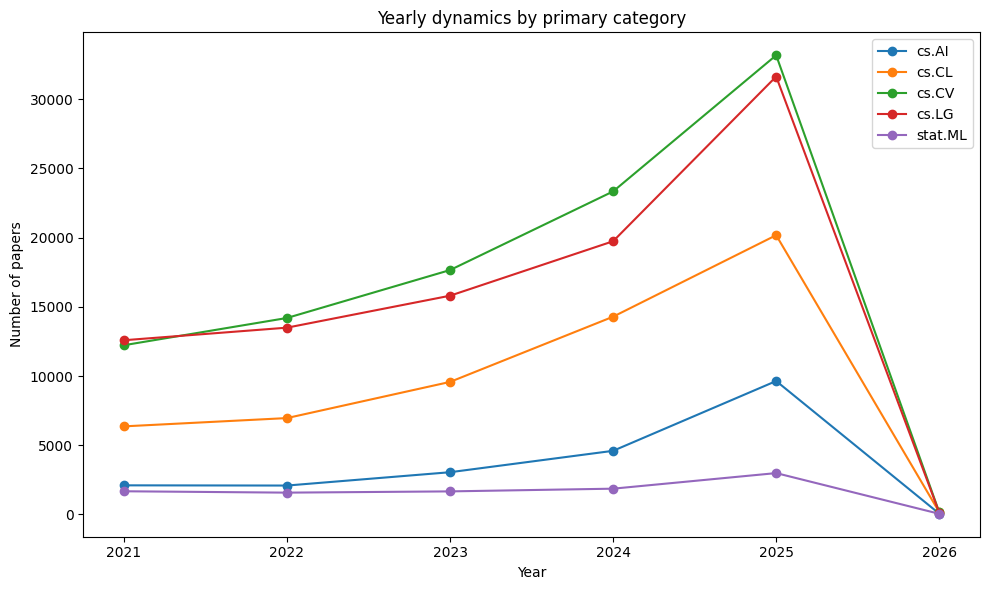

In [14]:
trend = (
    df.assign(year=lambda x: x["latest_version_created"].dt.year)
    .groupby(["year", "primary_category"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(10, 6))
for col in trend.columns:
    plt.plot(trend.index, trend[col].to_numpy(), marker="o", label=col)

plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.title("Yearly dynamics by primary category")
plt.legend()
plt.tight_layout()
plt.show()

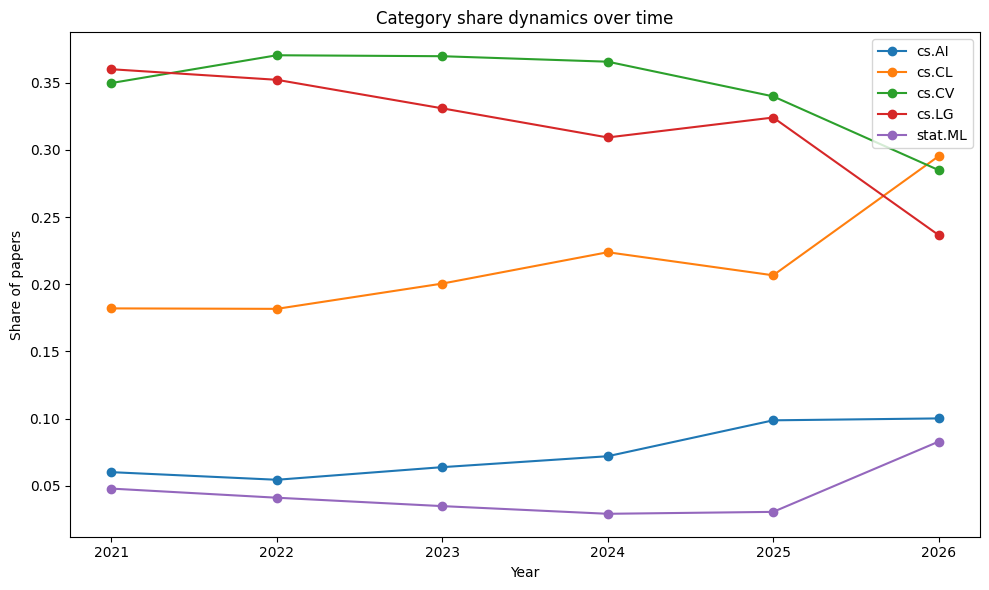

In [15]:
trend_share = trend.div(trend.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
for col in trend_share.columns:
    plt.plot(trend_share.index, trend_share[col].to_numpy(), marker="o", label=col)

plt.xlabel("Year")
plt.ylabel("Share of papers")
plt.title("Category share dynamics over time")
plt.legend()
plt.tight_layout()
plt.show()

## Date analysis

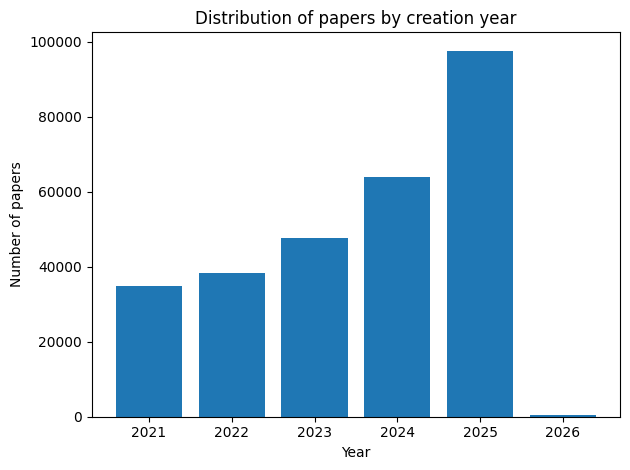

In [16]:
years = df["latest_version_created"].dt.year
year_counts = years.value_counts().sort_index()

plt.figure()
plt.bar(year_counts.index.to_numpy(), year_counts.to_numpy())
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.title("Distribution of papers by creation year")
plt.tight_layout()
plt.show()

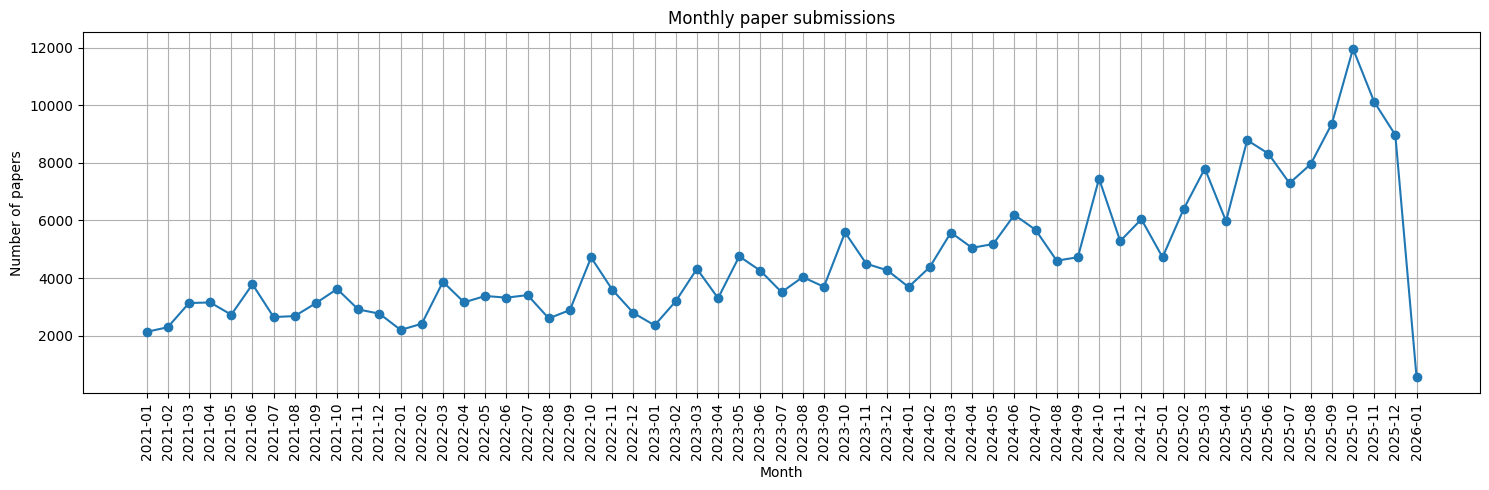

In [17]:
monthly_counts = (
    df.assign(month=lambda x: x["latest_version_created"].dt.to_period("M")).groupby("month").size()
)


plt.figure(figsize=(15, 5))
plt.plot(monthly_counts.index.astype(str), monthly_counts, marker="o")
plt.xticks(rotation=90)
plt.xlabel("Month")
plt.ylabel("Number of papers")
plt.title("Monthly paper submissions")
plt.grid(True)
plt.tight_layout()
plt.show()

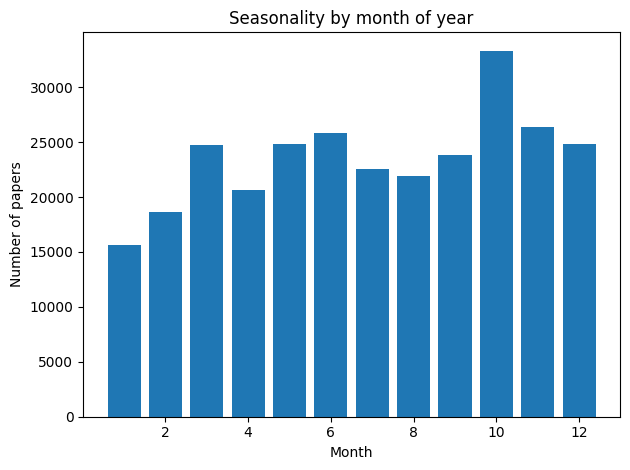

In [18]:
month_of_year = df["latest_version_created"].dt.month
month_counts = month_of_year.value_counts().sort_index()

plt.figure()
plt.bar(month_counts.index, month_counts.to_numpy())
plt.xlabel("Month")
plt.ylabel("Number of papers")
plt.title("Seasonality by month of year")
plt.tight_layout()
plt.show()